# Data Gathering 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings(action="ignore")
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We will not use all of the instances, however we will sample 10000 rows from the dataset ensuring the new dataframe has no missing values regarding the Customer ID.

In [4]:
df_id = pd.DataFrame(df[df['CustomerID'].notnull()])

In [5]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [6]:
# Sample the dataset
df_selected = df_id.sample(10000, random_state = 0)
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 209444 to 175411
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  10000 non-null  object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   10000 non-null  float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 703.1+ KB


# RFM Table

we create RFM table to make the data more interpretable and easier to conduct our segmentation analysis. 

In [7]:
# removing time part 
df_selected['InvoiceDate'] = pd.to_datetime(df_selected['InvoiceDate'])
df_selected['InvoiceDate'] = df_selected['InvoiceDate'].dt.date

# Create Total colummn
df_selected['Total'] = df_selected['Quantity'] * df_selected['UnitPrice']

# create snapshot_date one day after the last day in Invoide date
snapshot_date = max(df_selected.InvoiceDate) + timedelta(days=1)

# Aggregate data by each customer
data_process = df_selected.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Total': 'sum'})
# Rename columns
data_process.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'Total': 'MonetaryValue'}, inplace=True)

In [8]:
data_process

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,8,243.50
12349.0,19,2,34.80
12354.0,233,1,20.40
12355.0,215,1,19.90
12356.0,326,2,172.80
...,...,...,...
18270.0,241,1,-38.25
18272.0,46,3,50.55
18281.0,181,1,16.50


# Data Preprocessing (Skewness and Feature Scaling)

<b>
While K-means clustering is a simple, fast Unsupervised Learning Algorithm, it requires our data to meet certain assumptions:

1. Symmetric distribution of variables
2. Variables have the same mean and variance 
<b>

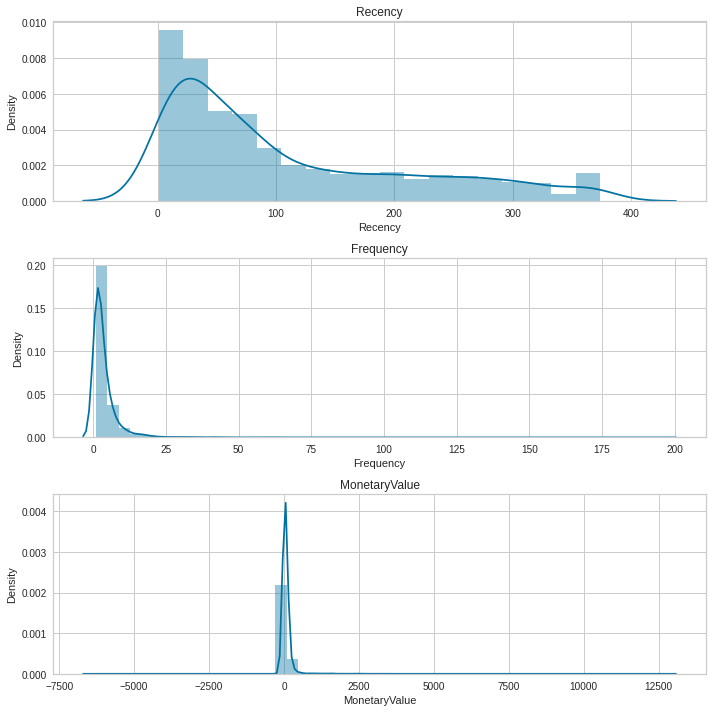

In [9]:
# we use for loop to plot the probability density curve for each feature separately

plt.figure(figsize=(10,10))
for i in range(len(data_process.columns)):
  plt.subplot(3,1,i+1)
  sns.distplot(data_process[data_process.columns[i]])
  plt.title(data_process.columns[i])
plt.tight_layout()


it is clear that all the variables are skewed and not following a normal distribution.

In [10]:
data_process.skew(axis=0)

Recency           1.018155
Frequency        14.454903
MonetaryValue    17.351801
dtype: float64

We can see that our variables are highly skewed so we would prefer either Logarithmic or Box-Cox Transformation to Square Root Transformation

## Logarithmic vs Box-Cox Transformation

In [11]:
box_re = stats.boxcox(data_process['Recency'])[0]
box_fre = stats.boxcox(data_process['Frequency'])[0]

In [12]:
log_re = np.log(data_process['Recency'])
log_fre = np.log(data_process['Frequency'])

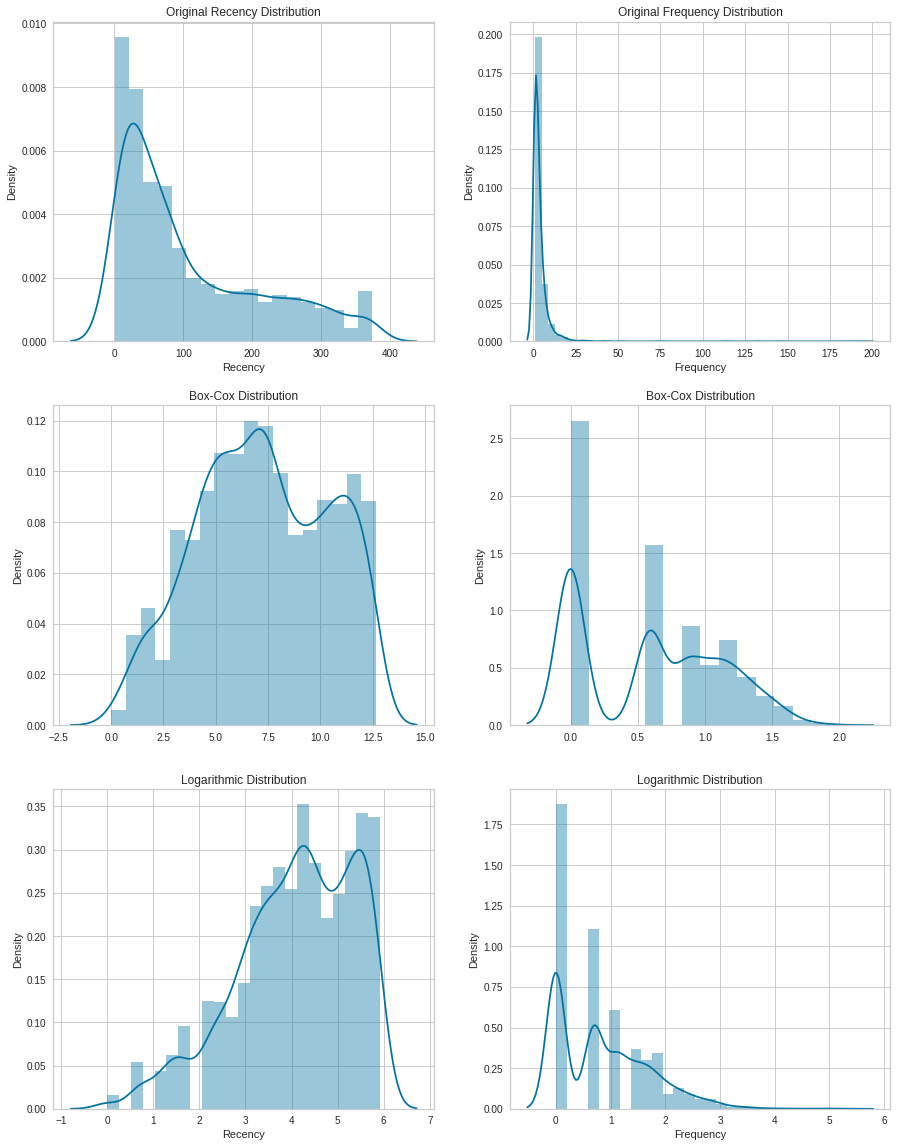

In [13]:
fig = plt.figure(figsize=(15,20))
ax0 = fig.add_subplot(321)
ax1 = fig.add_subplot(322)
ax2 = fig.add_subplot(323)
ax3 = fig.add_subplot(324)
ax4 = fig.add_subplot(325)
ax5 = fig.add_subplot(326)

sns.distplot(data_process['Recency'], ax=ax0)
sns.distplot(box_re, ax=ax2)
sns.distplot(log_re, ax=ax4)
sns.distplot(data_process['Frequency'], ax=ax1)
sns.distplot(box_fre, ax=ax3)
sns.distplot(log_fre, ax=ax5)

ax0.set_title('Original Recency Distribution')
ax1.set_title('Original Frequency Distribution')
ax2.set_title('Box-Cox Distribution')
ax3.set_title('Box-Cox Distribution')
ax4.set_title('Logarithmic Distribution')
ax5.set_title('Logarithmic Distribution')

plt.show()

Based on these visuals, we can see that the variables with box-cox transformation shows a more symmetrical form rather than the logarithmic transformation.

In [14]:
data_process[data_process['MonetaryValue']<0]

,Recency,Frequency,MonetaryValue
CustomerID,,,
12454.0,54,2,-550.40
12457.0,67,3,-42.45
12479.0,5,1,-5.00
12504.0,22,1,-12.75
12802.0,184,1,-15.00
12951.0,299,1,-8.50
13085.0,226,1,-12.60
13369.0,355,1,-3.78
13466.0,101,1,-9.95


We can apply neither Box-Cox nor Logarithmic Transformation to Monetary Value as both methods require our data to contain only positive values, so we will use cubic root transformation instead.

In [15]:
cb_MV = np.cbrt(data_process['MonetaryValue']).values

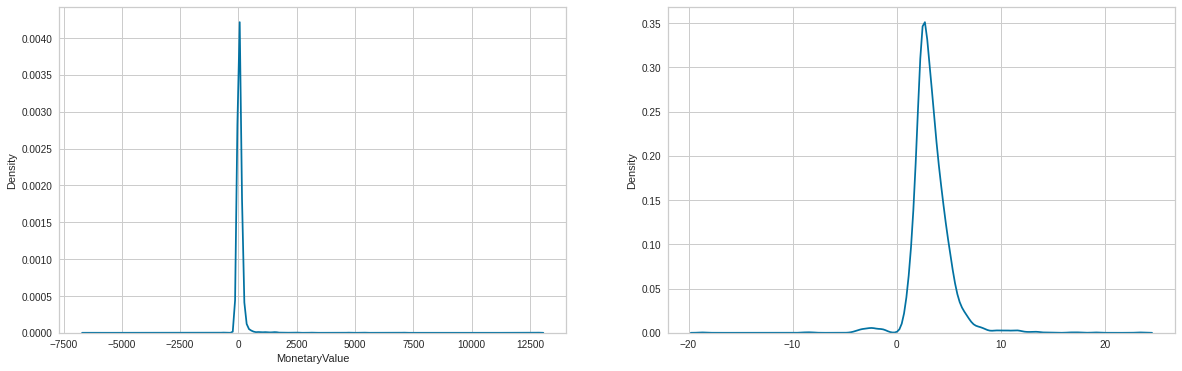

In [16]:
fig = plt.figure(figsize=(20,6))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.kdeplot(data_process['MonetaryValue'], ax=ax0)
sns.kdeplot(cb_MV, ax=ax1)

plt.show()

This comparison shows the original distribution of Monetary Value on the left with its distribution after applying cbrt on the right.

In [17]:
final_df = pd.DataFrame({'Recency': box_re, 
                         'Frequency': box_fre, 
                          'MonetaryValue': cb_MV})
final_df.head()

,Recency,Frequency,MonetaryValue
0,5.817362,1.320447,6.244529
1,4.215313,0.590466,3.264824
2,10.909712,0.000000,2.732394
3,10.629554,0.000000,2.709886
4,12.137878,0.590466,5.569907


In [18]:
final_df.skew()

Recency         -0.084822
Frequency        0.163943
MonetaryValue    0.950222
dtype: float64

we can see that with proper preprocessing of our data, we have reduced data skewness to approximately 0 as it tends to be more normally distributed. 

# Feature Scaling

In [19]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
data_scaled = scaler.fit_transform(final_df)

In [20]:
# assert variables have mean of 0
data_scaled.mean(axis=0).round(2)

array([-0.,  0., -0.])

In [21]:
# assert variables have variance of 1
data_scaled.std(axis=0).round(2)

array([1., 1., 1.])

# Model Development

After ensuring that our data meets the assumptions of Kmeans algorithm, we can start building our model to perform clustering. However, we need to determine which hyperparametes fits to our data in order to reach it maximum efficiency. thus, we use the elbow method.

In [22]:
# find the optimal value of K using elbow method
K_range = range(1,10)
wcss = []
for i in K_range:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

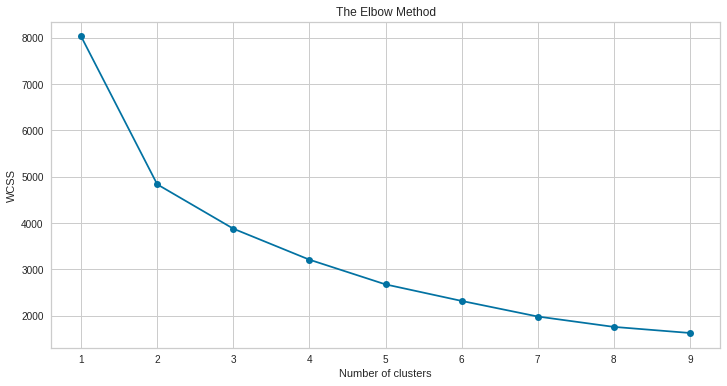

In [23]:
plt.figure(figsize = (12,6))

plt.plot(K_range, wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(K_range)
plt.show()

we can see that our best bet would be 3 to 5 clusters where values start to reduce more linearly and the curve is no longer falling steeply, However, we can perform silhouette analysis to reach a more decisive decision.

# Silhouette Analysis

In [24]:
K_range = range(2,10)
sil_score = []
for i in K_range:
    kmeans2 = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    labels = kmeans2.fit(data_scaled).labels_
    sil_score.append(silhouette_score(data_scaled, labels))

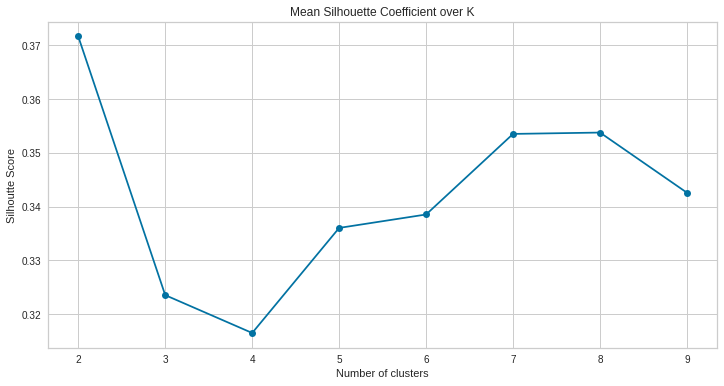

In [25]:
plt.figure(figsize = (12,6))

plt.plot(K_range, sil_score , marker='o')
plt.title('Mean Silhouette Coefficient over K')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte Score')
plt.xticks(K_range)
plt.show()

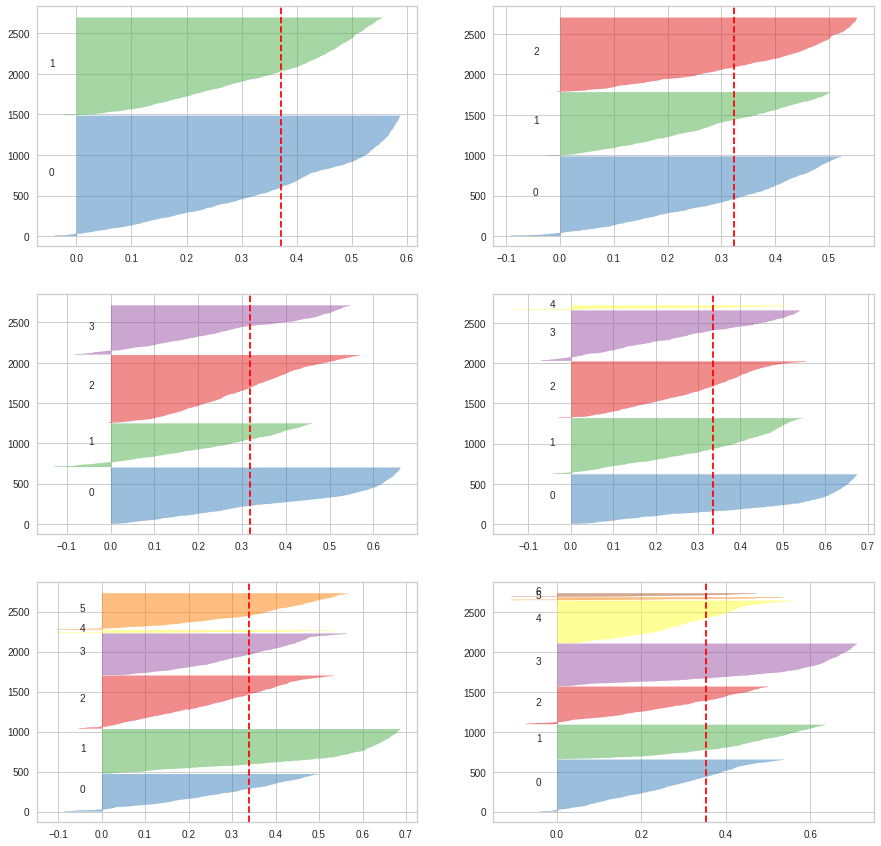

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
for i in range(2,8):
    km = KMeans(n_clusters=i, init='k-means++', random_state=42)
    # use divmod method to specify ax for our plots
    q, mod = divmod(i, 2)
  
    # Create SilhouetteVisualizer instance with KMeans instance
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    # Fit the visualizer
    visualizer.fit(data_scaled)

we conduct our silhouette analysis based on two main principles:
- similariy in thinkness of silhouette plots which represent each cluster
-  presence of negative values, meaning that b(i) is higher than a(i)

accordingly, we can exclude all numbers of clusters other than 2 and 3.
however, we can see that 3 clusters achieve less fluctuation in thickness of silhouette plots, so we choose 3 to be our number of clusters to achieve the maximum performance.

In [27]:
# initialize and fit the model to our data
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(data_scaled)
clusters.shape

(2676,)

# Feature Extraction with PCA

Dimentionality Reduction - Integrating a multi-dimensional space (columns) into 2 dimensions to make evaluating our business case easier to understand. There is no particular meaning assigned to each principalcomponent, as the new components are just 2 main dimensions of the variation. It is mainly conducted to easily visualize our clusters on a 2-D graph.

In [28]:
# reducing number of features to 2 using principal component analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(data_scaled)
principal_comp

array([[ 2.03739430e+00, -7.36539455e-01],
       [ 4.78621844e-01,  7.81336299e-01],
       [-1.51480504e+00, -6.33773236e-01],
       ...,
       [-1.43068165e+00, -3.53686263e-01],
       [-1.30994747e+00,  1.49277208e-03],
       [ 2.33011439e+00,  1.05000822e+00]])

In [29]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,2.037394,-0.736539
1,0.478622,0.781336
2,-1.514805,-0.633773
3,-1.475687,-0.555275
4,-0.110349,-1.984073


In [30]:
# Concatenate the clusters labels to the datafram
pca_cluster_df = pd.concat([pca_df, pd.DataFrame({'clusters': clusters})], axis=1)
pca_cluster_df

,pca1,pca2,clusters
0,2.037394,-0.736539,1
1,0.478622,0.781336,0
2,-1.514805,-0.633773,2
3,-1.475687,-0.555275,2
4,-0.110349,-1.984073,2
...,...,...,...
2671,-3.425943,1.331052,2
2672,0.620884,0.098901,1
2673,-1.430682,-0.353686,2
2674,-1.309947,0.001493,2


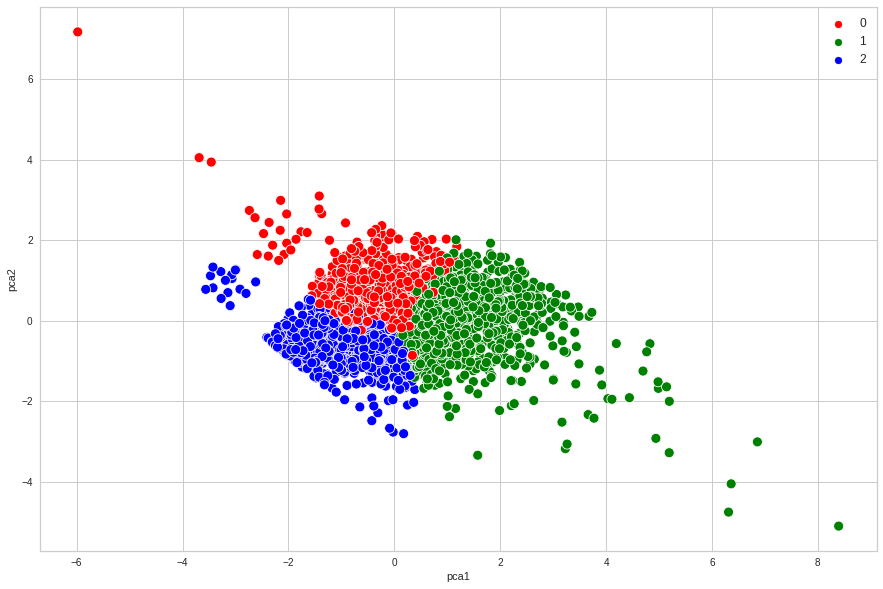

In [31]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='pca1', y='pca2', hue = 'clusters', data = pca_cluster_df,
                palette =['red','green','blue'], s=100)
plt.legend(fontsize=12)
plt.show()

In [32]:
# concatenate clusters to the original dataframe
data_cluster = pd.concat([data_process.reset_index(), pd.DataFrame({'Clusters': clusters})], axis=1)

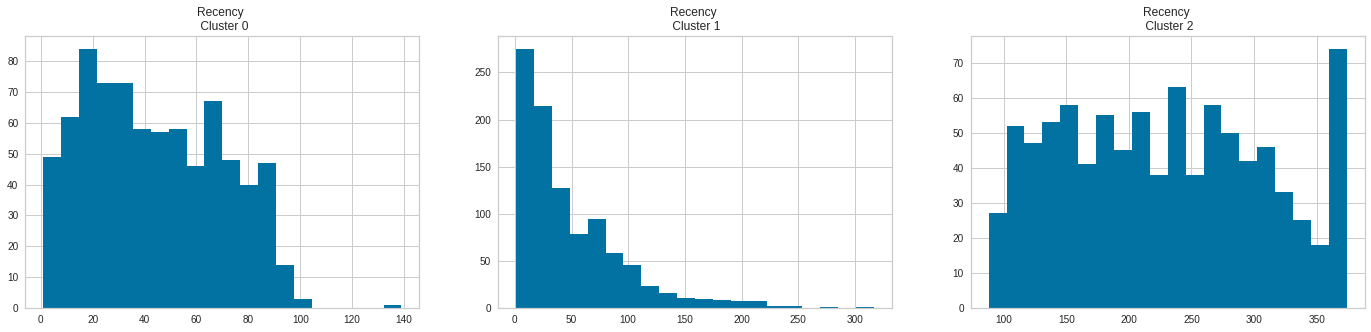

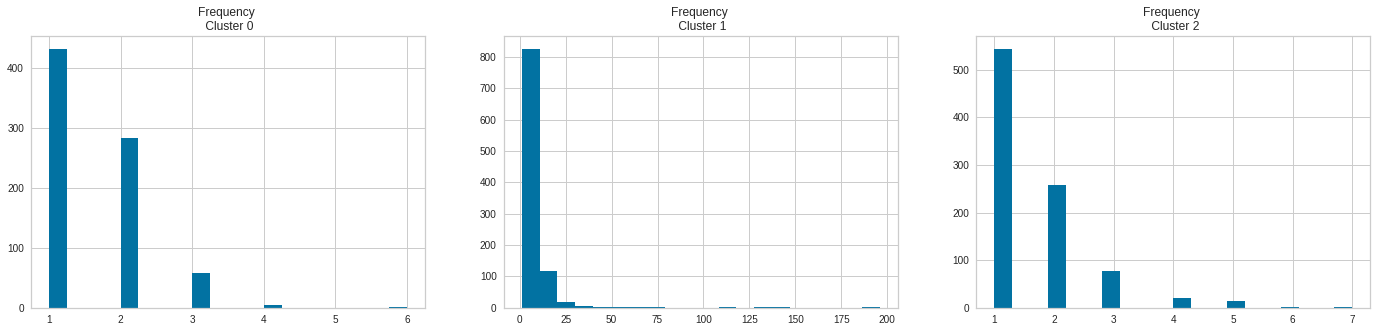

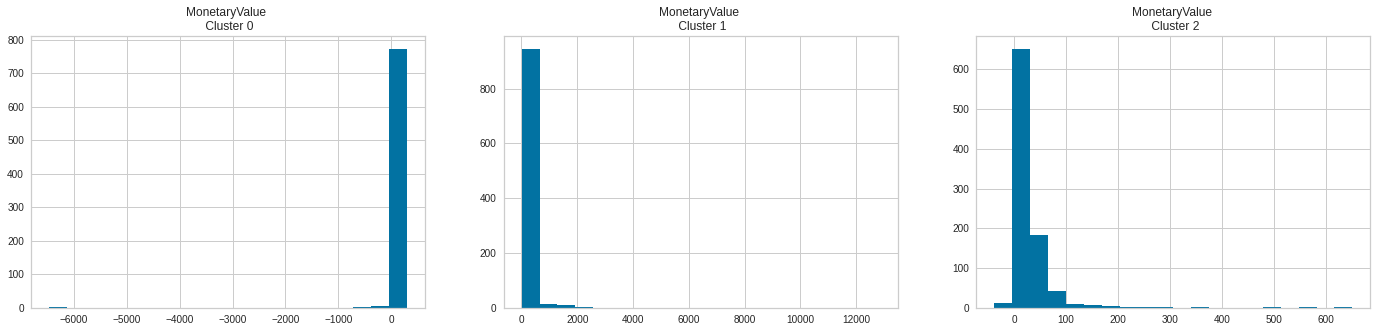

In [33]:
# Plot the histogram of various clusters
for i in final_df:
  plt.figure(figsize = (24, 5))
  for j in range(3):
    plt.subplot(1,3,j+1)
    cluster = data_cluster[data_cluster['Clusters'] == j]
    cluster[i].hist(bins=20)
    plt.title(f'{i} \n Cluster {j}')
  
  plt.show()

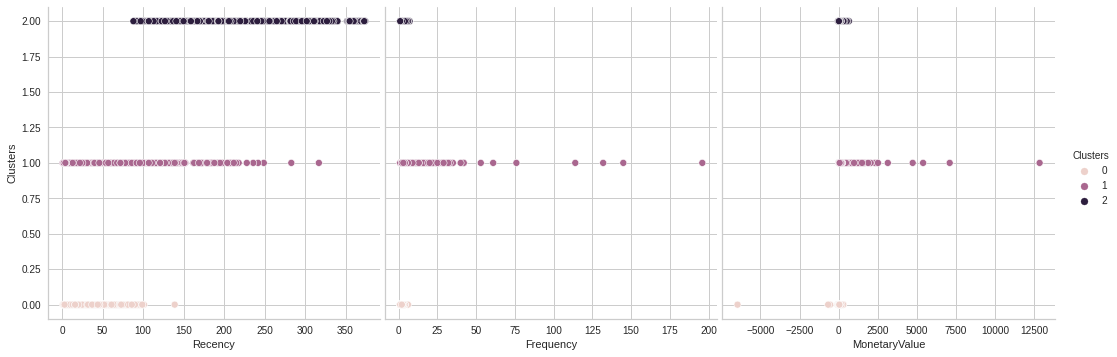

In [34]:
sns.pairplot(data_cluster, hue='Clusters', x_vars=['Recency', 'Frequency', 'MonetaryValue'],
            y_vars=['Clusters'], height=5)
plt.show()

# Insights and Marketing Strategies

After performing customer segmentation exploiting RFM marketing analysis tool, we now have a more cohesive picture of our customer base, to conclude our clustering analysis, we can observe 3 distinct groups where our customers fit in as follows:

-  group 1 (cluster 0) are our long-standing customers, those who come last in terms of recency, Frequency or even Monetary Value, as we can see they made less orders with  a low monetary value a long time ago.

> Strategy: we can design more specifically targeted communication that help convert them into more loyal, higher RFM value customers. 

- group 2 (cluster 1) are our loyal customers, they come first in terms of Frequency with large-value orders, However, they are the second most recent customers who made purchases, WE CAN'T LOSE THEM.

> Strategy: a more personalized offers can be promoted using product recommendation based on their past purchases in order to increase engagement and ensure higher customer retention rate.

- group 3 (cluster 2) are our new customer base, they are the most recent customers who made purchases, slightly higher in monetary value than group 1, However less frequent than group 2, which makes perfect sense they are newly introduced to our product.

> Strategy: triggered welcome emails can be used to ensure engagement, establishing personal connection,  encourage them to make more purchases with introductory offers.


